In [1]:
import os
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 101)
pd.set_option('display.width', 1000)

# Data preprocessing

In [3]:
DATA_DIR = 'housing_prices'
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), sep=',').drop_duplicates().drop(["Id"], axis=1)

print(df.shape)
df.head(2)

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
quality_map_1 = {
    'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1
}
df['ExterQual'] = df['ExterQual'].map(quality_map_1)
df['ExterCond'] = df['ExterCond'].map(quality_map_1)
df['KitchenQual'] = df['KitchenQual'].map(quality_map_1)


df_info = pd.DataFrame(index=df.columns)
df_info['nan_counts'] = df.isnull().sum().rename('nan_counts')
df_info['n_unique'] = pd.Series([len(df[col].unique()) for col in df.columns], index=df.columns)
df_info['dtype'] = df.dtypes

# define which variable is going to be categorical
# OverallQual, OverallCond, ExterQual, ExterCond, KitchenQual (have to be converted to numerical values)
# BsmtQual, BsmtCond, BsmtExposure, HeatingQC contain `NaN` and will be kept as categorical variables
df_info['categorical'] = (df_info['n_unique'] < 40).astype(int)
df_info.loc[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'KitchenQual'], 'categorical'] = 0

df_info.loc[df_info['categorical']==0].sort_values(by=['nan_counts'], ascending=[False]).head(8)

,nan_counts,n_unique,dtype,categorical
LotFrontage,259,111,float64,0
GarageYrBlt,81,98,float64,0
MasVnrArea,8,328,float64,0
1stFlrSF,0,753,int64,0
ScreenPorch,0,76,int64,0
EnclosedPorch,0,120,int64,0
OpenPorchSF,0,202,int64,0
WoodDeckSF,0,274,int64,0


,GarageType,GarageYrBlt
39,NaN,NaN


,GarageType,GarageYrBlt
39,NaN,NaN


,MasVnrType,MasVnrArea
234,NaN,NaN


,MasVnrType,MasVnrArea
234,NaN,NaN


<AxesSubplot:>

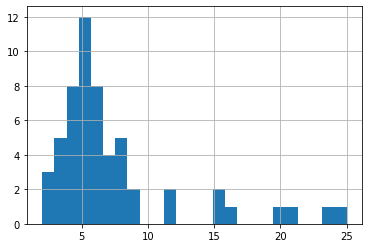

In [5]:
# Look at the nans of the continuous variables
#

# Only in cases when there is no garage (GarageType=nan), GarageYrBlt = nan
display(df.loc[df['GarageType'].isnull(), ['GarageType', 'GarageYrBlt']].drop_duplicates())
display(df.loc[df['GarageYrBlt'].isnull(), ['GarageType', 'GarageYrBlt']].drop_duplicates())

# Only in cases when there Masonry is None, MasVnrArea = nan
display(df.loc[df['MasVnrType'].isnull(), ['MasVnrType', 'MasVnrArea']].drop_duplicates())
display(df.loc[df['MasVnrArea'].isnull(), ['MasVnrType', 'MasVnrArea']].drop_duplicates())

# The LotFrontage will be dropped

# Each categorical variable has at most 25 unique values which is ok.
df_info.loc[df_info['categorical']==1, 'n_unique'].hist(bins=25)

In [6]:
target = 'SalePrice'
columns_to_drop = ['LotFrontage']

features_categorical = df_info[df_info['categorical'] == 1].index.values.tolist()
features_continuous = df_info[df_info['categorical'] == 0].index.values.tolist()

for cols in [features_categorical, features_continuous]:
    cols = list(filter(lambda x: x != target, cols))
    cols = list(filter(lambda x: x not in columns_to_drop, cols))

features = features_categorical + features_continuous

# map all categorical values to integers
label_encoders = dict()
for col in features_categorical:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].fillna('NA').apply(str))

# Train a model

In [7]:
def lgbm_rmse(preds, train_data):
    targets = train_data.get_label()
    return 'rmse', mean_squared_error(targets, preds, squared=False), False

X_train, X_test, Y_train, Y_test = train_test_split(
    df[features], df[target], test_size = 0.1, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size = 1./9, random_state=42)

y_scale = StandardScaler()

Y_train_scl = y_scale.fit_transform(Y_train.values.reshape(-1,1))
Y_val_scl = y_scale.transform(Y_val.values.reshape(-1,1))
Y_test_scl = y_scale.transform(Y_test.values.reshape(-1,1))

print(X_train.shape, X_val.shape, X_test.shape)

# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train, 
    Y_train_scl.reshape(-1), 
    feature_name=features,
    categorical_feature=features_categorical,
    free_raw_data=False)

lgb_eval = lgb.Dataset(
    X_val, 
    Y_val_scl.reshape(-1), 
    feature_name=features,
    categorical_feature=features_categorical,
    reference=lgb_train, 
    free_raw_data=False)

lgb_test = lgb.Dataset(
    X_val, 
    Y_test_scl.reshape(-1), 
    feature_name=features,
    categorical_feature=features_categorical,
    reference=lgb_train, 
    free_raw_data=False)


(1168, 80) (146, 80) (146, 80)


In [8]:
params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 10,
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    'metric': 'l2', # {'l2', 'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 5,
    'learning_rate': 0.02,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'lambda_l2': 0.1,
     # 'feature_name': features,
    'categorical_feature': features_categorical,
}

evals_result=dict()

gbm = lgb.train(
    params,
    lgb_train,
    valid_names=['val'],
    valid_sets=[lgb_eval],
    feval=lgbm_rmse,
    # fobj,
    feature_name=features,
    categorical_feature=features_categorical,
    verbose_eval=10,
    evals_result=evals_result
)


/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format

Training until validation scores don't improve for 10 rounds
[10]	val's l2: 0.606126	val's rmse: 0.778541
[20]	val's l2: 0.448495	val's rmse: 0.669698
[30]	val's l2: 0.312458	val's rmse: 0.558979
[40]	val's l2: 0.217997	val's rmse: 0.466901
[50]	val's l2: 0.156203	val's rmse: 0.395225
[60]	val's l2: 0.119509	val's rmse: 0.345701
[70]	val's l2: 0.091241	val's rmse: 0.302061
[80]	val's l2: 0.0683253	val's rmse: 0.261391
[90]	val's l2: 0.0532871	val's rmse: 0.23084
[100]	val's l2: 0.0423209	val's rmse: 0.20572
[110]	val's l2: 0.0356258	val's rmse: 0.188748
[120]	val's l2: 0.0328952	val's rmse: 0.18137
[130]	val's l2: 0.0295521	val's rmse: 0.171907
[140]	val's l2: 0.0273613	val's rmse: 0.165412
[150]	val's l2: 0.0261324	val's rmse: 0.161655
[160]	val's l2: 0.0254473	val's rmse: 0.159522
[170]	val's l2: 0.0243723	val's rmse: 0.156116
[180]	val's l2: 0.0238687	val's rmse: 0.154495
[190]	val's l2: 0.0232163	val's rmse: 0.152369
[200]	val's l2: 0.0231291	val's rmse: 0.152083
[210]	val's l2: 0.

In [9]:
Y_hat_train = y_scale.inverse_transform(gbm.predict(X_train))
Y_hat_val = y_scale.inverse_transform(gbm.predict(X_val))
Y_hat_test = y_scale.inverse_transform(gbm.predict(X_test))

# Evaluation of the calibration of predictions

In [10]:
from sklearn.utils import gen_even_slices

def _mean_prediction_by_percentile(
    y_true, y_pred, sample_weight=None, n_bins=100
):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    # y_span_min, y_span_max = y_true.min(), y_true.max()
    # dy = (y_span_max - y_span_min) / n_bins
    
    # bin_centers = np.arange(y_span_min, y_span_max, dy) + 0.5 * dy
    # bin_centers = np.ones(shape=(n_bins,))
    bin_centers = np.arange(0, 1, 1/n_bins) + 0.5/n_bins
    
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(
            y_pred[idx_sort][sl], weights=weights
        )
        y_true_bin[n] = np.average(
            y_true[idx_sort][sl],
            weights=weights
        )
        # bin_centers[n] = y_pred_bin[n]
        
    return bin_centers, y_true_bin, y_pred_bin


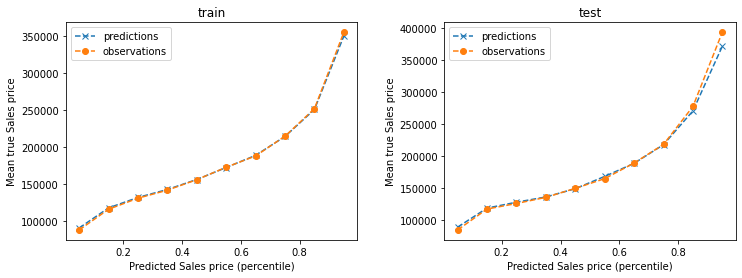

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

for axi, y, y_hat, name in zip(ax.ravel(), 
                               [Y_train.values, Y_test.values], 
                               [Y_hat_train, Y_hat_test],
                               ['train', 'test']):

    q, y_true_seg, y_pred_seg = _mean_prediction_by_percentile(
        y, y_hat, sample_weight=np.ones_like(y), n_bins=10)

    axi.plot(q, y_pred_seg, marker='x', linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker='o', linestyle="--", label="observations")

    axi.set(
        title=name,
        xlabel='Predicted Sales price (percentile)', # 'Predicted Sales price',
        ylabel='Mean true Sales price'
    )
    axi.legend()


# Train a model (Poisson regression)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df[features], df[target], test_size = 0.1, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size = 1./9, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train, 
    Y_train.values, 
    feature_name=features,
    categorical_feature=features_categorical,
    free_raw_data=False)

lgb_eval = lgb.Dataset(
    X_val, 
    Y_val.values, 
    feature_name=features,
    categorical_feature=features_categorical,
    reference=lgb_train, 
    free_raw_data=False)

lgb_test = lgb.Dataset(
    X_val, 
    Y_test.values, 
    feature_name=features,
    categorical_feature=features_categorical,
    reference=lgb_train, 
    free_raw_data=False)


(1168, 80) (146, 80) (146, 80)


In [13]:
params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 20,
    'boosting_type': 'gbdt', 
    'objective': 'poisson',
    # 'metric': 'l2', # {'l2', 'l1'},
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
     # 'feature_name': features,
    'categorical_feature': features_categorical,
}

evals_result=dict()

gbm = lgb.train(
    params,
    lgb_train,
    valid_names=['val'],
    valid_sets=[lgb_eval],
    feval=lgbm_rmse,
    # fobj,
    feature_name=features,
    categorical_feature=features_categorical,
    verbose_eval=10,
    evals_result=evals_result
)


/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/A.IVA/opt/anaconda3/envs/hp/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format

Training until validation scores don't improve for 20 rounds
[10]	val's poisson: -1.94248e+06	val's rmse: 63242.8
[20]	val's poisson: -1.94466e+06	val's rmse: 56293.8
[30]	val's poisson: -1.94658e+06	val's rmse: 49210.8
[40]	val's poisson: -1.94808e+06	val's rmse: 42879.1
[50]	val's poisson: -1.94918e+06	val's rmse: 37588.7
[60]	val's poisson: -1.94994e+06	val's rmse: 33525.4
[70]	val's poisson: -1.95051e+06	val's rmse: 30146.2
[80]	val's poisson: -1.95097e+06	val's rmse: 27086.7
[90]	val's poisson: -1.95135e+06	val's rmse: 24253
[100]	val's poisson: -1.95163e+06	val's rmse: 22155.5
[110]	val's poisson: -1.95189e+06	val's rmse: 20087.2
[120]	val's poisson: -1.95208e+06	val's rmse: 18412.3
[130]	val's poisson: -1.95223e+06	val's rmse: 16973.4
[140]	val's poisson: -1.95232e+06	val's rmse: 16122.4
[150]	val's poisson: -1.95243e+06	val's rmse: 15106.7
[160]	val's poisson: -1.95249e+06	val's rmse: 14422.6
[170]	val's poisson: -1.95255e+06	val's rmse: 13816.1
[180]	val's poisson: -1.9526e+06

In [14]:
Y_hat_train = gbm.predict(X_train)
Y_hat_val = gbm.predict(X_val)
Y_hat_test = gbm.predict(X_test)

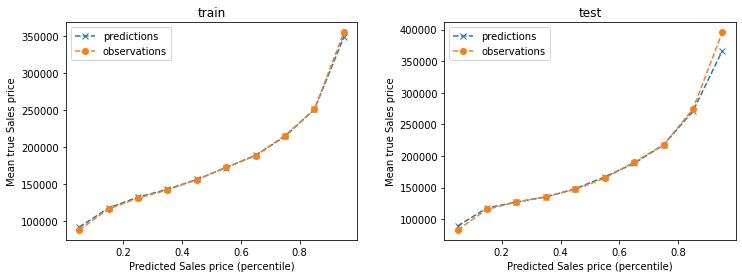

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

for axi, y, y_hat, name in zip(ax.ravel(), 
                               [Y_train.values, Y_test.values], 
                               [Y_hat_train, Y_hat_test],
                               ['train', 'test']):

    q, y_true_seg, y_pred_seg = _mean_prediction_by_percentile(
        y, y_hat, sample_weight=np.ones_like(y), n_bins=10)

    axi.plot(q, y_pred_seg, marker='x', linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker='o', linestyle="--", label="observations")

    axi.set(
        title=name,
        xlabel='Predicted Sales price (percentile)', # 'Predicted Sales price',
        ylabel='Mean true Sales price'
    )
    axi.legend()
